In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import os
import re
import random
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Reshape, Dropout
from keras import optimizers
from keras.callbacks import TensorBoard
import sys
from keras.utils import plot_model

Using TensorFlow backend.


## Constants

In [2]:
NUMBER_OF_GENRES = 8
TRAIN_FILES_DIR = './train_files/'
CSV_FILE_PATH = './small_train_labels.csv'

In [3]:
csv_file = pd.read_csv(CSV_FILE_PATH)
all_genres = csv_file['genre'].unique()
genre_to_index = {genre: index for index, genre in enumerate(all_genres)}

In [4]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

## Hyper Parameters

In [8]:
UNIFORM_IMAGE_SIZE = (1000, 1000)
EPOCHS = 20
BATCH_SIZE = 10
LEARNING_RATE = 0.01
START = 0
FINISH = 100

In [9]:
def build_train_and_test_data():
  train_data = []
  train_labels = []

  list_of_files = os.listdir(TRAIN_FILES_DIR)[START:FINISH]
  for file_index, file in enumerate(list_of_files):
    raw_image = Image.open(TRAIN_FILES_DIR + file)
    resized_image = raw_image.resize(UNIFORM_IMAGE_SIZE)
    image_tensor = np.asarray(resized_image)
    train_data.append(image_tensor)

    file_as_str_number = re.sub('([a-z])|(\.)', '', file)
    label_name = csv_file[csv_file['track_id'] == int(file_as_str_number)]['genre'].values[0]
    train_labels.append(genre_to_index[label_name])
  return (
    np.array(train_data).astype(np.float32),
    np.array(train_labels, np.int32)
  )

In [10]:
train_data, train_labels = build_train_and_test_data()
train_data /= 255

dummy_labels = np.zeros((len(train_labels), NUMBER_OF_GENRES), np.float32)

for index, label in enumerate(train_labels):
  dummy_labels[index][label] = 1

In [11]:
model = Sequential()

model.add(
  Conv2D(6, (5, 5),
         data_format="channels_last",
         padding="same",
         strides=1,
         input_shape=(1000, 1000, 4)
        )
)
model.add(MaxPooling2D(pool_size=(5, 5), strides=5))
model.add(
  Conv2D(12, (5, 5),
         data_format="channels_last",
         padding="same",
         strides=1,
         input_shape=(500, 500, 6)
        )
)
model.add(MaxPooling2D(pool_size=(5, 5), strides=5))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(NUMBER_OF_GENRES, activation="softmax"))

model.compile(optimizer=optimizers.Adadelta(lr=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0716 22:49:14.891326 139644841965312 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 22:49:14.893570 139644841965312 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 22:49:14.897939 139644841965312 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0716 22:49:14.913701 139644841965312 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0716 22:49:14.931324 139644841965312 deprecation_wrapp

In [12]:
plot_model(model, to_file='model.png')

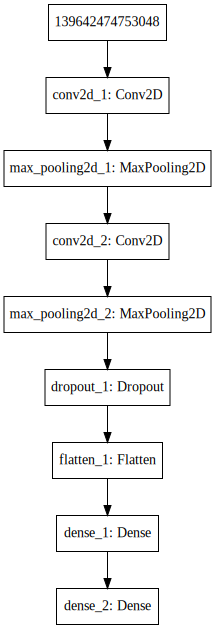

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [14]:
history = model.fit(
  train_data,
  dummy_labels,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
  verbose=1
)

W0716 22:49:30.391713 139644841965312 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 80 samples, validate on 20 samples
Epoch 1/20
80/80 [==============================] - 7s 89ms/step - loss: 2.2289 - acc: 0.1125 - val_loss: 2.1077 - val_acc: 0.1000
Epoch 2/20
80/80 [==============================] - 4s 53ms/step - loss: 2.0937 - acc: 0.1625 - val_loss: 2.0902 - val_acc: 0.1500
Epoch 3/20
80/80 [==============================] - 4s 53ms/step - loss: 2.0467 - acc: 0.2125 - val_loss: 2.0847 - val_acc: 0.1000
Epoch 4/20
80/80 [==============================] - 4s 52ms/step - loss: 1.9838 - acc: 0.2625 - val_loss: 2.0340 - val_acc: 0.2500
Epoch 5/20
80/80 [==============================] - 4s 53ms/step - loss: 2.0516 - acc: 0.2750 - val_loss: 1.9677 - val_acc: 0.2000
Epoch 6/20
80/80 [==============================] - 4s 53ms/step - loss: 1.9146 - acc: 0.4000 - val_loss: 1.9584 - val_acc: 0.2500
Epoch 7/20
80/80 [==============================] - 4s 53ms/step - loss: 1.9236 - acc: 0.3000 - val_loss: 1.9544 - val_acc: 0.3000
Epoch 8/20
80/80 [=====================

In [25]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
# Save entire model
model.save('whole_model.h5')

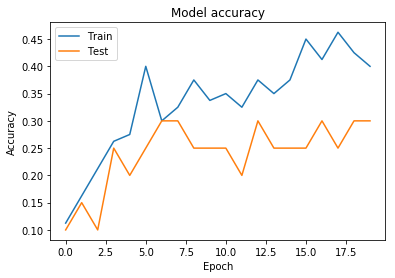

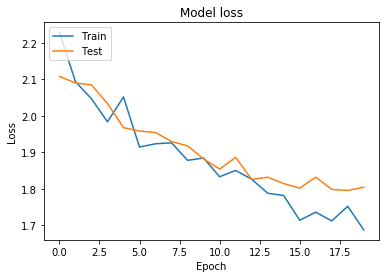

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
history.history

{'acc': [0.12500000186264515,
  0.12500000279396772,
  0.1750000026077032,
  0.15000000316649675,
  0.12500000279396772,
  0.1500000050291419,
  0.1000000024214387,
  0.12500000279396772,
  0.2000000039115548,
  0.21250000596046448],
 'loss': [2.1717496812343597,
  2.1269959062337875,
  2.1014203131198883,
  2.0955384969711304,
  2.086530715227127,
  2.107286259531975,
  2.0721189826726913,
  2.066954270005226,
  2.0800295919179916,
  2.0477344691753387],
 'val_acc': [0.10000000149011612,
  0.15000000223517418,
  0.10000000149011612,
  0.05000000074505806,
  0.05000000074505806,
  0.05000000074505806,
  0.15000000223517418,
  0.10000000149011612,
  0.10000000149011612,
  0.10000000149011612],
 'val_loss': [2.2366178035736084,
  2.218693494796753,
  2.203678607940674,
  2.1923086643218994,
  2.1800873279571533,
  2.170585870742798,
  2.161180257797241,
  2.1524921655654907,
  2.144503951072693,
  2.1380029916763306]}